In [4]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
from numpy import matmul
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from numpy import ndarray

import scipy.optimize

plt.rcParams["figure.figsize"] = (20, 10)

In [5]:
"""
Finds gradient of function fun in point x with precision O(h^2).
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
@param args_num: number of function arguments (not parameters)
"""
class ParametrizedFun:
    def __init__(self, fun:Callable[[List[float], List[float]], float], args_num:int):
        self.fun = fun
        self.args_num = args_num

    def at_point(self, x:List[float]):
        return partial(self.fun, x)

    def with_params(self, b:List[float]):
        return partial(self.fun, b=b)

def np_map(fun:Callable[[List[float]], float], a:List[List[float]]) -> ndarray:
    return np.array(list(map(fun, a)))

def generate_dataset(parametrized_fun:ParametrizedFun, b:List[float], size:int=100, r:tuple=(-10, 10), deviation:float=1):
    eval_fun = parametrized_fun.with_params(b)
    features = np.random.rand(size, parametrized_fun.args_num) * (r[1] - r[0]) + r[0]
    error = np.random.normal(0, deviation, size)
    dependent_var = np_map(eval_fun, features) + error
    return [features, dependent_var]

class SumFun:
    def __init__(self, features:List[List[float]], dependent_var:List[float], fun:ParametrizedFun):
        self._fun = fun
        self.terms = np.empty(len(features), dtype=partial)
        self.r = np.empty(len(features), dtype=partial)
        for i in range(len(features)):
            self.r[i] = partial(lambda features, dependent_var, b: (fun.at_point(features))(b) - dependent_var, features[i], dependent_var[i])
            self.terms[i] = partial(lambda features, dependent_var, b: np.square(fun.at_point(features)(b) - dependent_var), features[i], dependent_var[i])
        self.fun = reduce(lambda f1, f2: lambda x: f1(x) + f2(x), self.terms)

    @classmethod
    def from_fun(cls, fun:Callable):
        f = ParametrizedFun(lambda x, b: fun(b), 0)
        features = [[]]
        dependent_var = [0]
        return SumFun(features, dependent_var, f)

    def evaluate_r(self, x:ndarray) -> List[float]:
        res = np.empty(len(self.r), dtype=float)
        for i in range(len(self.r)):
            res[i] = self.r[i](x)
        return res

    def r_grad(self, x:ndarray) -> ndarray:
        j = np.zeros((len(self.r), len(x)))
        for i in range(len(self.r)):
            j[i] = grad(self.r[i], x)
        return j

    def grad(self, x:ndarray) -> ndarray:
        return 2 * np.matmul(self.r_grad(x).transpose(), self.evaluate_r(x))

    def hess_appr(self, x:ndarray) -> ndarray:
        j = self.r_grad(x)
        return 2 * np.matmul(j.transpose(), j)

    def get_model(self, x:ndarray):
        fun = self.get_fun()(x)
        g = self.grad(x)
        h = self.hess_appr(x)
        return partial(lambda fun, g, h, p: fun + matmul(g.transpose(), p) + 1/2 * matmul(matmul(p.transpose(), h), p), fun, g, h)

    def get_fun(self):
        return self.fun

def gauss_newton(fun:SumFun, x:List[float], max_epoch:int, lr:float=1, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = sum_fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        p = -matmul(inv(fun.hess_appr(x)), fun.grad(x))
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x = x + lr * 1e-4 * p
        else:
            x = x + lr * alpha[0] * p
        points.append(x)
    return np.array(points)

def plot_path_contours(sum_fun:SumFun, points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = sum_fun.get_fun()
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('Descent path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

def print_result(points:ndarray, actual_min:ndarray=None, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    if actual_min is None:
        print(f'Precision: unknown')
    else:
        print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Iterations: {len(points)}')
    print(f'Path: {points}')

def bin_search(fun:Callable[[float], float], c:float, eps:float=1e-3, r:tuple=(0, 1)):
    left, right = r
    while right - left > eps:
        mid = (left + right) / 2
        if fun(mid) < c:
            left = mid
        else:
            right = mid
    return (left + right) / 2

def dogleg(fun:SumFun, x:List[float], max_epoch:int, delta:float, min_delta:float=0, max_delta:float=1e2,stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = fun.grad(x)
        h = fun.hess_appr(x)
        # print("h", h)
        b = -matmul(inv(h), g)
        if norm(b) <= delta:
            p = b
        else:
            a = -matmul(g.transpose(), g) / matmul(matmul(g.transpose(), h), g) * g
            if norm(a) > delta:
                p = delta / norm(a) * a
            else:
                ff = lambda t: norm(a + t * (b - a))
                p = a + bin_search(ff, delta) * (b - a)
        m = fun.get_model(x)
        k = (f(x) - f(x + p)) / (m(np.zeros(len(p)) - m(p)))
        x = x + p
        if k < 0.25:
            delta = max(delta / 4, min_delta)
        elif np.abs(norm(p) - delta) < 1e-5:
            delta = min(2 * delta, max_delta)
        points.append(x)
    return np.array(points)

def calc_next_h(h, s, y):
    r = 1 / matmul(y.transpose(), s)
    v = np.identity(len(s)) - r * matmul(y, s.transpose())
    return matmul(matmul(v.transpose(), h), v) + r * matmul(s, s.transpose())

def calc_next_p(s:ndarray, y:ndarray, g:ndarray) -> ndarray:
    q = g
    alpha = np.zeros(len(s))
    ro = np.zeros(len(s))
    for i in range(len(s) - 1, -1, -1):
        ro[i] = 1 / matmul(y[i].transpose(), s[i])
        alpha[i] = ro[i] * matmul(s[i].transpose(), q)
        q = q - alpha[i] * y[i]
    if len(s) > 0:
        h = matmul(s[-1].transpose(), y[-1]) / matmul(y[-1].transpose(), y[-1]) * np.identity(len(g))
    else:
        h = np.identity(len(g))
    r = matmul(h, q)
    for i in range(len(s)):
        beta = ro[i] * matmul(y[i].transpose(), r)
        r = r + s[i] * (alpha[i] - beta)
    return -r

def bfgs(fun:SumFun, x:ndarray, max_epoch:int, h0:ndarray=None, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    if h0 is None:
        h = inv(fun.hess_appr(x))
    else:
        h = h0
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = -matmul(h, g)
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s = x_next - x
        y = sum_fun.grad(x_next) - g
        h = calc_next_h(h, s, y)

        x = x_next
        points.append(x)
    return np.array(points)

def l_bfgs(fun:SumFun, x:ndarray, max_epoch:int, m:int=4, stop_criteria:Callable[[List[List[float]]], bool]=lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-4).all()) -> ndarray:
    points = [x]
    f = fun.get_fun()
    s = []
    y = []
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = calc_next_p(s, y, g)
        alpha = scipy.optimize.line_search(f, fun.grad, x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s.append(x_next - x)
        y.append(sum_fun.grad(x_next) - g)
        if len(s) > m:
            s.pop(0)
            y.pop(0)

        x = x_next
        points.append(x)
    return np.array(points)

def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

def sgd_adam(sum_fun:SumFun, x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = [x]
    m = 0
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun.terms, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points.append(x)
    return np.array(points)

In [10]:
from timeit import default_timer as timer

def test(sum_fun, tested_function, x, title="Unknown", max_epoch=200):
    stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
    start_time = timer()
    points = tested_function(sum_fun, x, max_epoch, stop_criteria=stop_criteria)
    time = timer() - start_time
    print(title)
    print(f'Deviation: {b - points[-1]}')
    print(f'Epochs: {len(points)}')
    print(f'Elapsed time: {time * 1000} ms')
    print(f'Time on epoch: {time / len(points) * 1000} ms\n')

# Euclid distance
n = 4
b = [1, 2, 3, 4]
parametrized_fun = ParametrizedFun(lambda x, b: x[0] ** 4 * b[0] + x[0] ** 3 * b[1] + x[0] ** 2 * b[2] + b[3], 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Euclid distance function")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

Euclid distance function
Dogleg
Deviation: [-2.29110995e-06 -2.69472826e-05 -4.97800423e-04  1.09928246e-02]
Epochs: 25
Elapsed time: 5270.779800004675 ms
Time on epoch: 210.831192000187 ms



In [3]:
from timeit import default_timer as timer

def test(sum_fun, tested_function, x, title="Unknown", max_epoch=200):
    stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
    start_time = timer()
    points = tested_function(sum_fun, x, max_epoch, stop_criteria=stop_criteria)
    time = timer() - start_time
    print(title)
    print(f'Deviation: {b - points[-1]}')
    print(f'Epochs: {len(points)}')
    print(f'Elapsed time: {time * 1000} ms')
    print(f'Time on epoch: {time / len(points) * 1000} ms\n')

n = 2
#Rosenbrock
b = [1, 100]
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))
sum_fun = SumFun.from_fun(rosenbrock)

print("Rosenbrock function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")

# Function from first lecture
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Function from first lecture")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Euclid distance
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Euclid distance function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Lineal function (two parameters)
b = [10, -4]
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + b[1] * x[0], 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Lineal function (two params)")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
start_time = timer()
# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)
points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
time = timer() - start_time
print("Adam")
print(f'Deviation: {b - points[-1]}')
print(f'Epochs: {len(points)}')
print(f'Elapsed time: {time * 1000} ms')
print(f'Time on epoch: {time / len(points) * 1000} ms\n')

# Lineal function (20 parameters)
n = 20
b = np.random.rand(n) * 20 - 10
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + np.sum(b[1:] * x), n - 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print(f'Lineal function ({n} params)')
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

Rosenbrock function
L-BFGS
Deviation: [1.14220413e-02 9.90228799e+01]
Epochs: 29
Elapsed time: 32.33290000935085 ms
Time on epoch: 1.1149275865293398 ms

Function from first lecture
L-BFGS
Deviation: [-8.93260378e-07  4.66239558e-06]
Epochs: 11
Elapsed time: 263.8829999923473 ms
Time on epoch: 23.98936363566794 ms

BFGS
Deviation: [-0.02039635  0.13765319]
Epochs: 200
Elapsed time: 5354.572900003404 ms
Time on epoch: 26.772864500017022 ms

Gauss-Newton
Deviation: [3.00301484e-09 1.91909391e-07]
Epochs: 7
Elapsed time: 159.35780000290833 ms
Time on epoch: 22.765400000415475 ms

Dogleg
Deviation: [1.19478827e-09 3.82127909e-08]
Epochs: 12
Elapsed time: 232.14969999389723 ms
Time on epoch: 19.34580833282477 ms

Euclid distance function
L-BFGS
Deviation: [-0.00773037 -0.02010248]
Epochs: 5
Elapsed time: 660.6515000021318 ms
Time on epoch: 132.13030000042636 ms

BFGS
Deviation: [-0.00764656 -0.02033683]
Epochs: 8
Elapsed time: 940.8721999934642 ms
Time on epoch: 117.60902499918302 ms

Gauss

## L-BFGS with rosenbrock

Precision: [0.45621066 0.71461831]
Min point: [0.54378934 0.28538169]
Iterations: 50
Path: [[0.         0.        ]
 [0.18886498 0.        ]
 [0.18389465 0.04185688]
 [0.20104053 0.0297521 ]
 [0.20799802 0.04800501]
 [0.22399266 0.04090484]
 [0.2368437  0.07069696]
 [0.25971307 0.04773295]
 [0.25804623 0.06754748]
 [0.28136544 0.06620398]
 [0.28263052 0.08530203]
 [0.2947809  0.07958748]
 [0.30375941 0.09977003]
 [0.31549064 0.0927976 ]
 [0.32408744 0.11131308]
 [0.33469635 0.10596345]
 [0.34405094 0.12412101]
 [0.36151211 0.11620017]
 [0.35870946 0.13367315]
 [0.37319117 0.12796009]
 [0.37244502 0.14078455]
 [0.38328194 0.13937917]
 [0.38602999 0.15331841]
 [0.39757115 0.14957383]
 [0.39828362 0.15943291]
 [0.41494848 0.16013907]
 [0.41278995 0.17181431]
 [0.42900217 0.17135001]
 [0.42622457 0.18263578]
 [0.43969435 0.18313607]
 [0.43831603 0.19242961]
 [0.45038236 0.19416593]
 [0.44983334 0.20233815]
 [0.46159518 0.20481454]
 [0.461165   0.21258735]
 [0.47247569 0.21528946]
 [0.47179

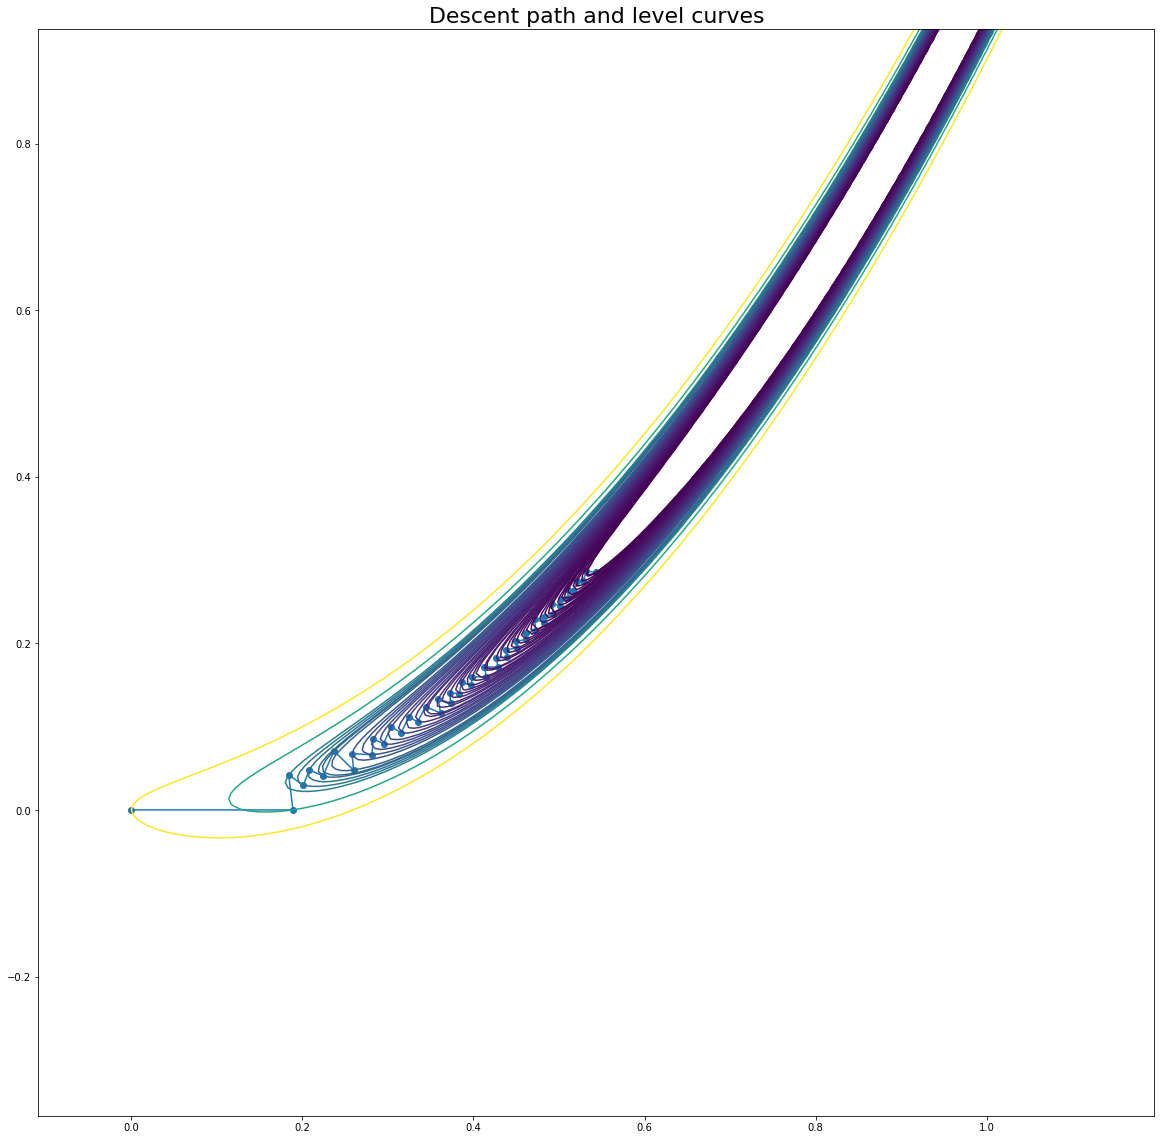

In [4]:
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))

sum_fun = SumFun.from_fun(rosenbrock)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50, h0=np.identity(len(x)))

min_point = np.array([1, 1])
print_result(points, min_point)
plot_path_contours(sum_fun, points)

## L-BFGS

Precision: [-6.52544268e-06 -1.24088041e-05]
Min point: [0.50000653 2.00001241]
Iterations: 11
Path: [[ 0.          0.        ]
 [ 0.43582683 -0.00646358]
 [ 0.27584207  0.01163164]
 [ 0.37738243  2.09206655]
 [ 0.40521808  2.33972006]
 [ 0.43332346  2.18554122]
 [ 0.48324649  1.97743031]
 [ 0.50038381  2.00427379]
 [ 0.50016624  1.99868256]
 [ 0.49992315  2.00009973]
 [ 0.50000653  2.00001241]]


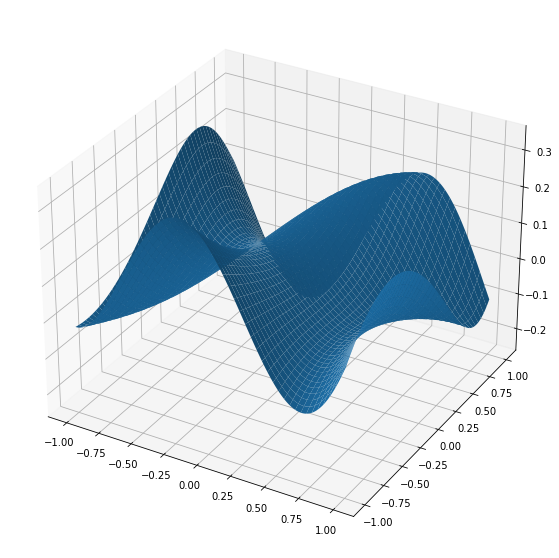

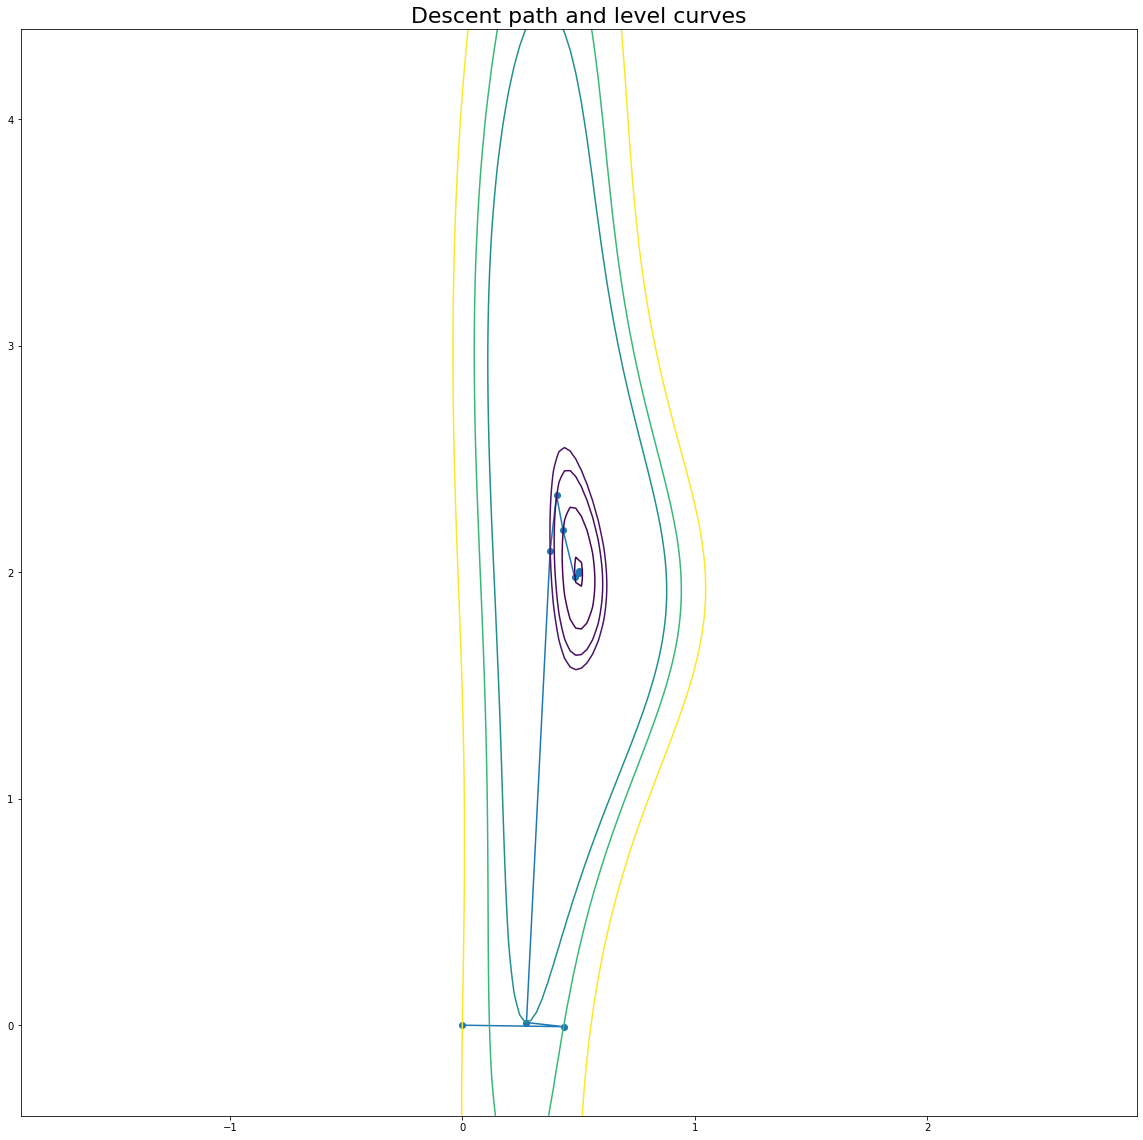

In [5]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = l_bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## BFGS

Precision: [-0.02022209  0.46903012]
Min point: [0.52022209 1.53096988]
Iterations: 50
Path: [[0.         0.        ]
 [0.36030056 0.17369313]
 [0.37911165 0.21357885]
 [0.35863821 0.4867827 ]
 [0.407163   0.5334268 ]
 [0.3893502  0.52059182]
 [0.43160504 0.58958229]
 [0.39774709 0.55961766]
 [0.37293385 0.56267344]
 [0.41266478 0.60617964]
 [0.39428772 0.59293895]
 [0.41908187 0.62887208]
 [0.39747161 0.61224039]
 [0.43252715 0.66821918]
 [0.40288143 0.64391421]
 [0.62759101 1.19715486]
 [0.49614379 1.08027434]
 [0.45438456 1.04294469]
 [0.42895242 1.03534334]
 [0.46990455 1.08084483]
 [0.44622014 1.06337854]
 [0.47934266 1.10617975]
 [0.45314932 1.08536437]
 [0.49576491 1.1486015 ]
 [0.46202592 1.12017653]
 [0.56706038 1.37504571]
 [0.50274961 1.31706995]
 [0.48157844 1.30121197]
 [0.50798471 1.33511574]
 [0.48435059 1.31602182]
 [0.51116487 1.35137   ]
 [0.48833179 1.33241743]
 [0.5199674  1.37923698]
 [0.49389886 1.35631293]
 [0.55993792 1.52231885]
 [0.51396272 1.4784493 ]
 [0.498

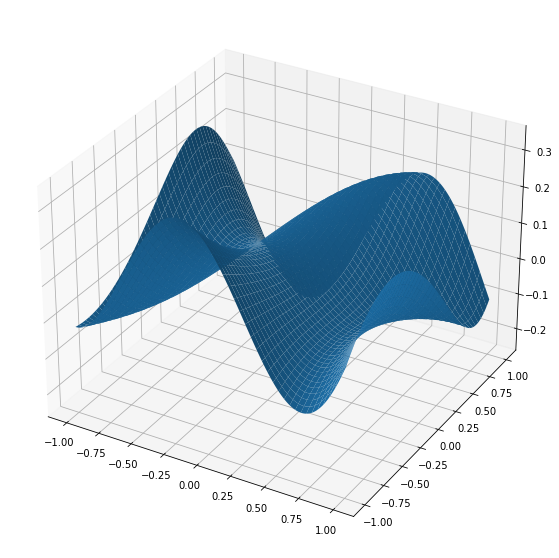

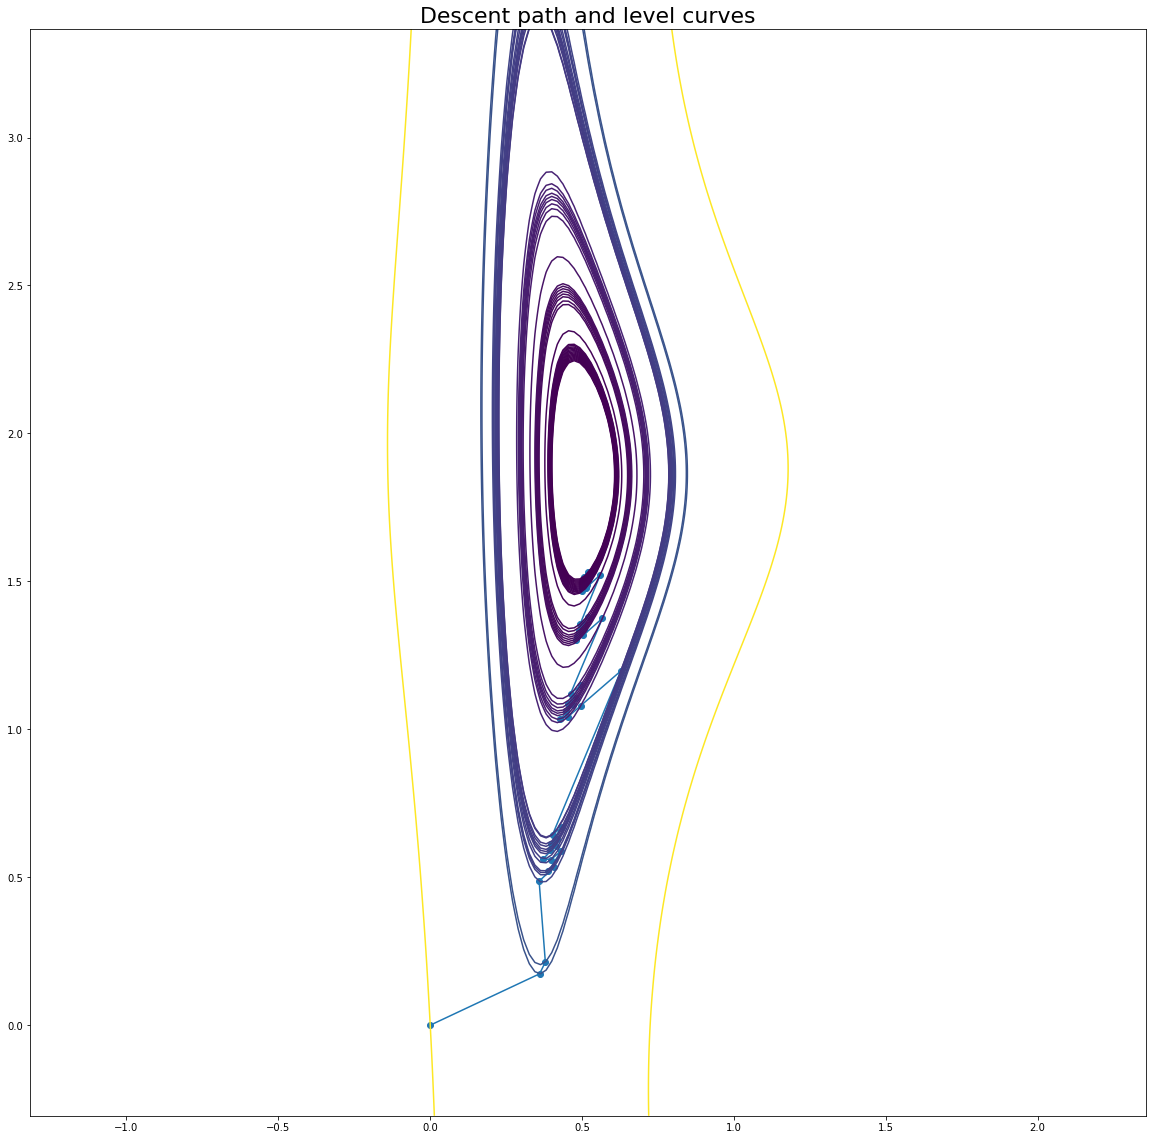

In [6]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Dogleg

Precision: [-0.01940714 -0.15023754]
Min point: [0.51940714 2.15023754]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 0.26390855 -0.02115112]
 [ 0.26088839  0.22884742]
 [ 0.27647458  0.40652851]
 [ 0.29555206  0.63437479]
 [ 0.32843789  0.88221959]
 [ 0.37515351  1.12799643]
 [ 0.43359285  1.37117332]
 [ 0.50401402  1.61094648]
 [ 0.45084946  1.85522814]
 [ 0.51997776  2.09560973]
 [ 0.51976253  2.14783974]
 [ 0.5194298   2.15010428]
 [ 0.51940843  2.15022996]
 [ 0.51940721  2.15023711]
 [ 0.51940715  2.15023752]
 [ 0.51940714  2.15023754]
 [ 0.51940714  2.15023754]
 [ 0.51940714  2.15023754]
 [ 0.51940714  2.15023754]]


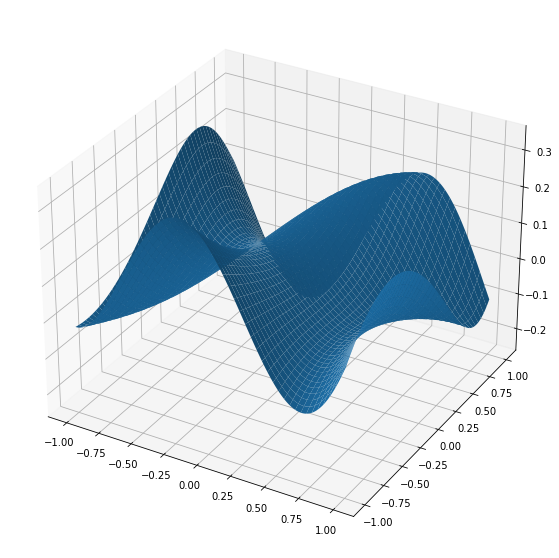

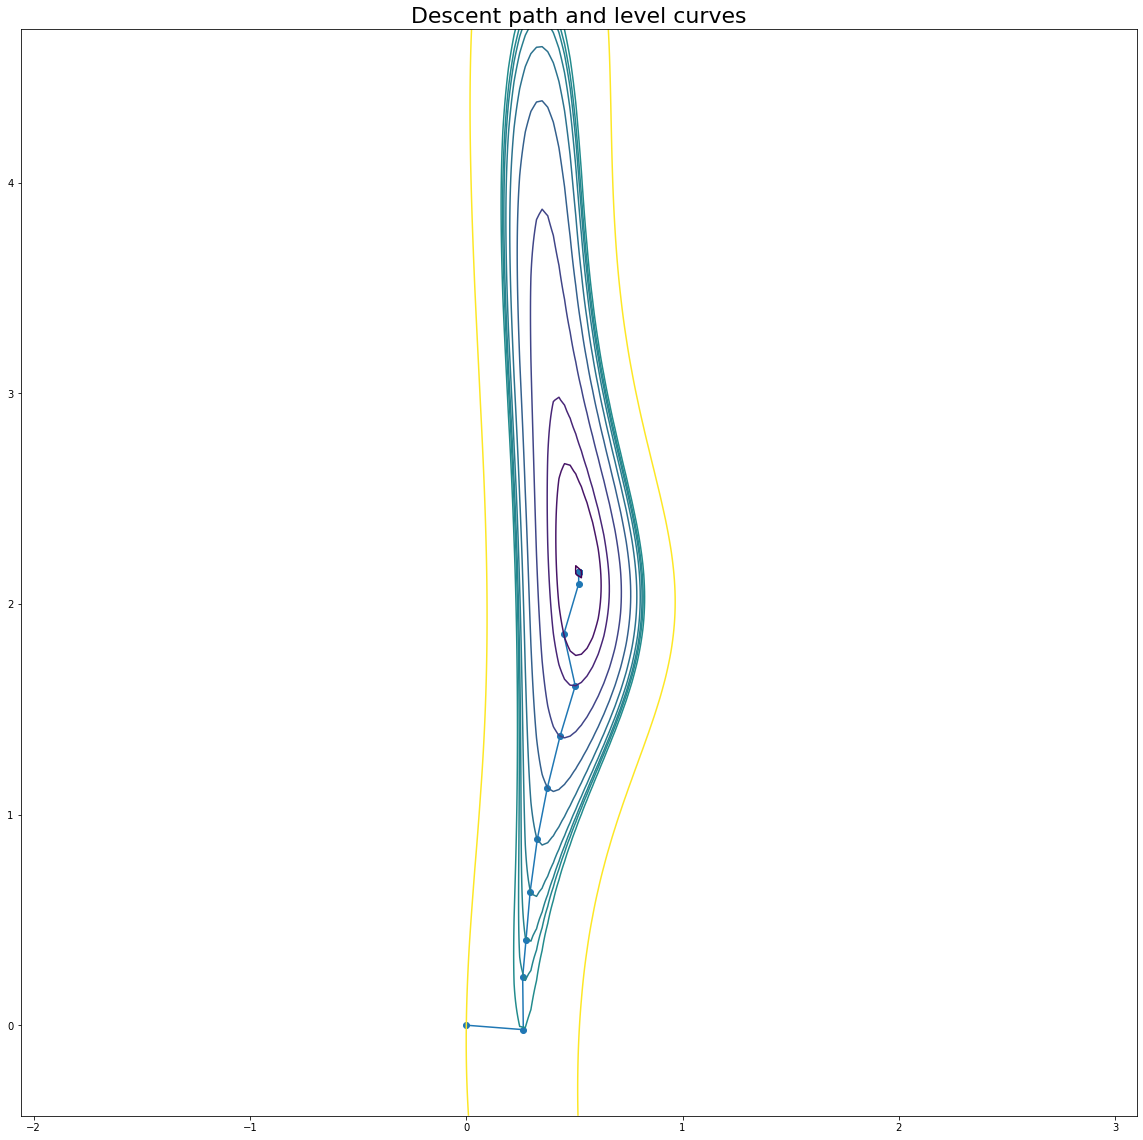

In [7]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = dogleg(sum_fun, x, 20, 1, min_delta=0.25)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Gauss-Newton

C:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Precision: [-2.66453526e-15 -2.22044605e-15]
Min point: [4. 3.]
Iterations: 20
Path: [[0.         0.        ]
 [3.48297807 2.57718242]
 [4.00203093 2.99685327]
 [4.00000046 3.00000025]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]
 [4.         3.        ]]


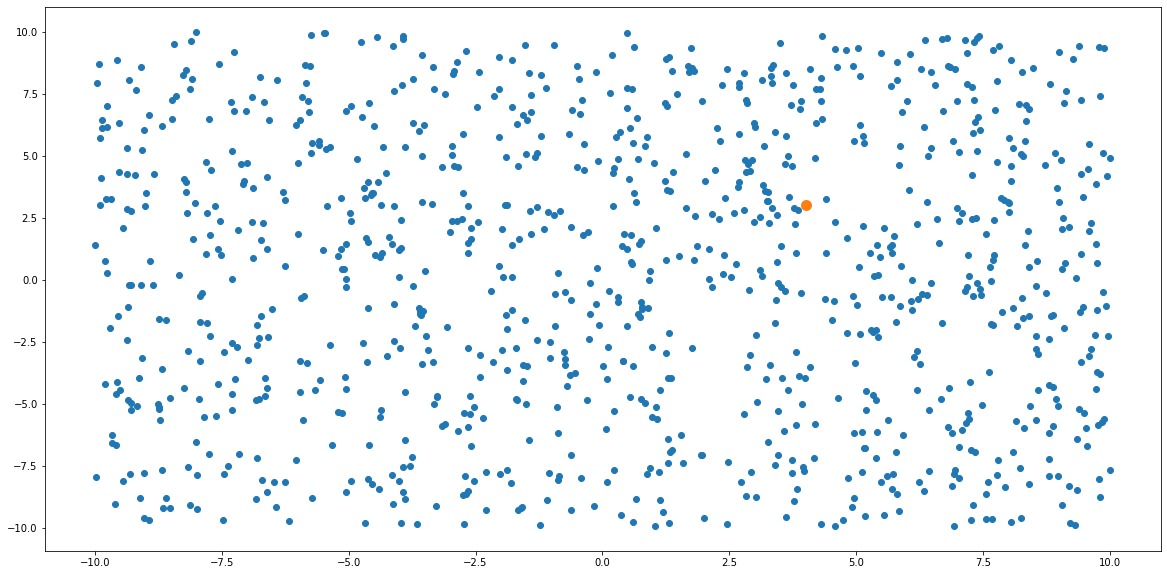

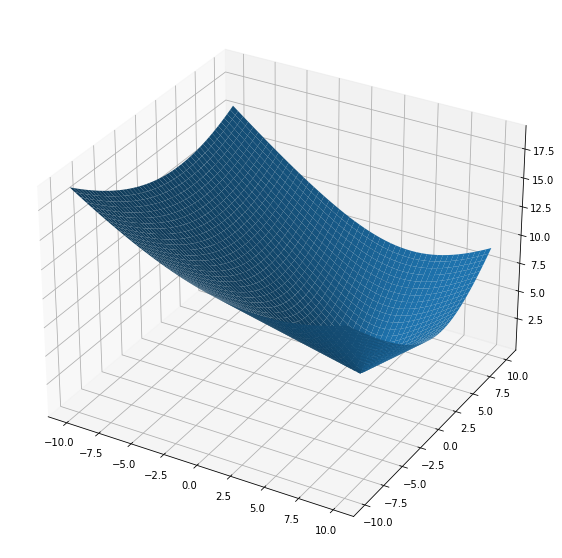

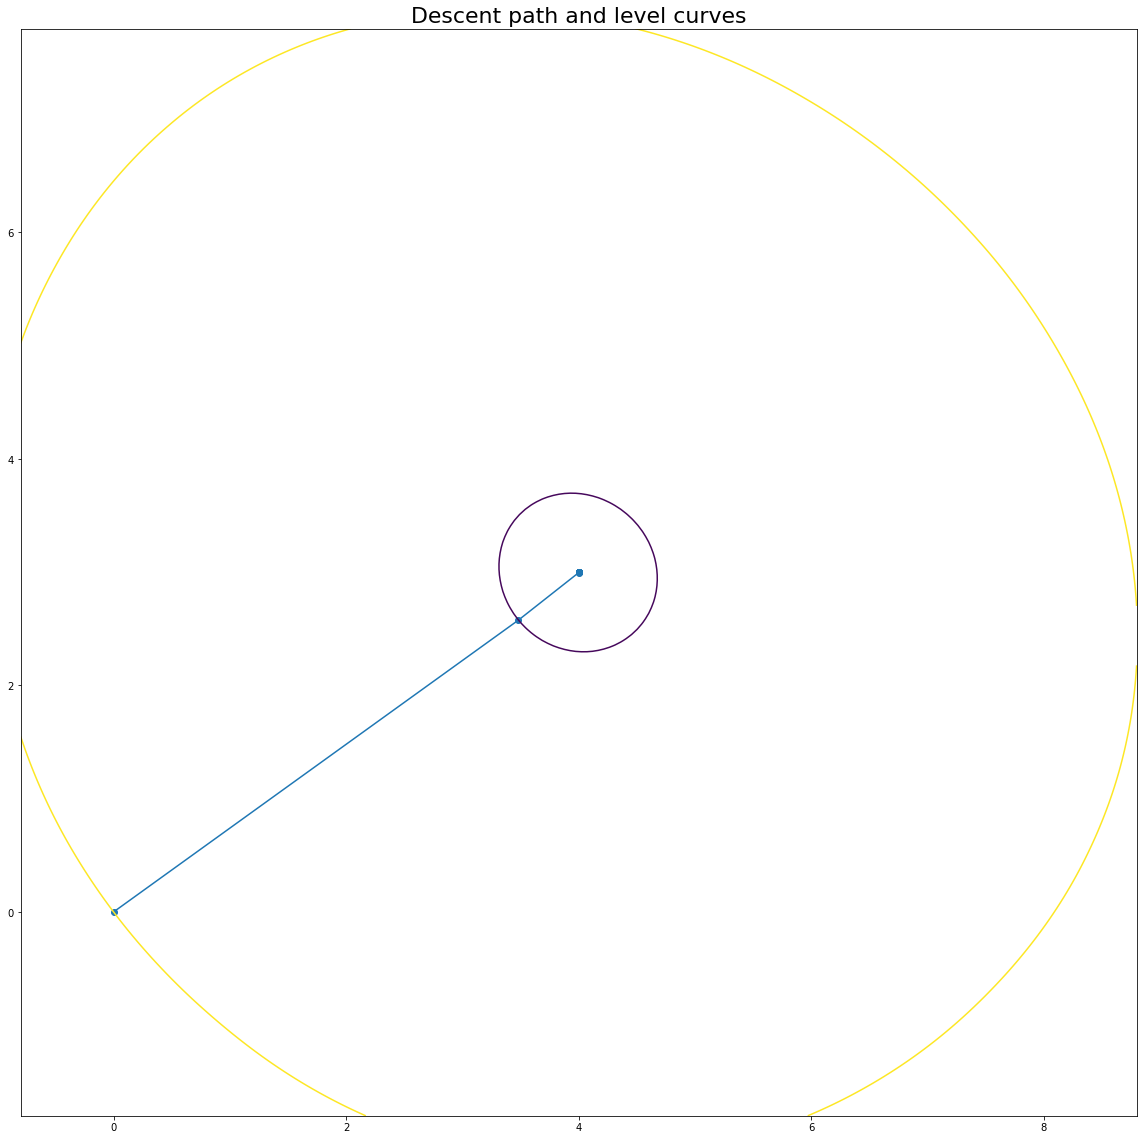

In [11]:
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Практическая задача

Precision: unknown
Min point: [ 0.45930784 -0.79099126]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 0.07011417 -0.12538761]
 [ 0.13168978 -0.23091032]
 [ 0.18303843 -0.32115796]
 [ 0.22620941 -0.3981225 ]
 [ 0.26294094 -0.46352801]
 [ 0.29441225 -0.51899891]
 [ 0.32144444 -0.56600682]
 [ 0.34467667 -0.60583226]
 [ 0.36464046 -0.63957027]
 [ 0.38178967 -0.66815127]
 [ 0.39651528 -0.69236408]
 [ 0.40915495 -0.71287684]
 [ 0.42000033 -0.7302554 ]
 [ 0.42930317 -0.74497894]
 [ 0.43728055 -0.75745329]
 [ 0.44411957 -0.76802214]
 [ 0.44998131 -0.77697663]
 [ 0.45500434 -0.78456337]
 [ 0.45930784 -0.79099126]]


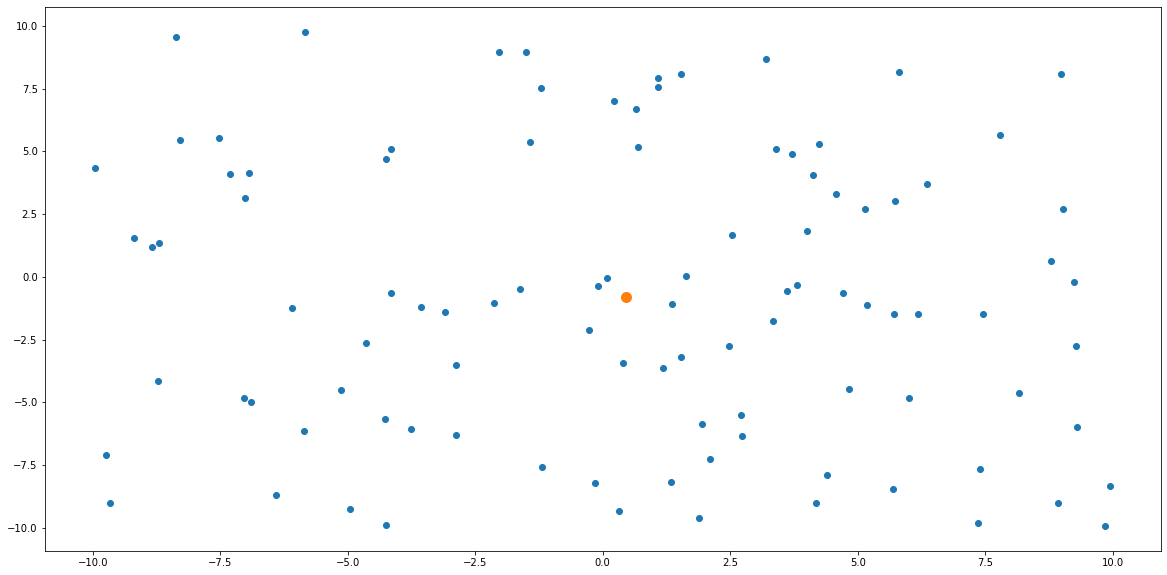

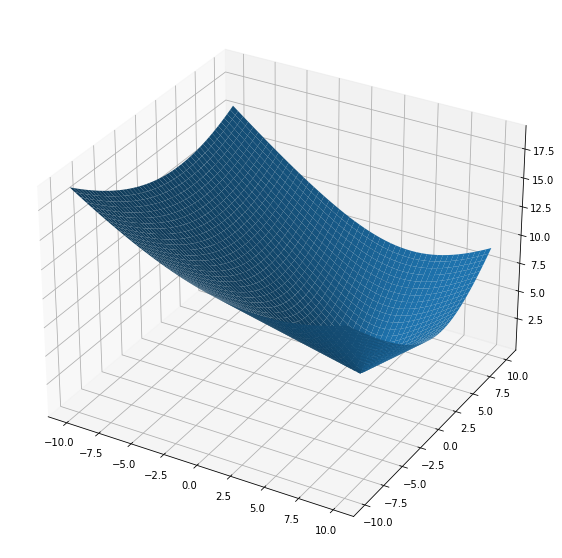

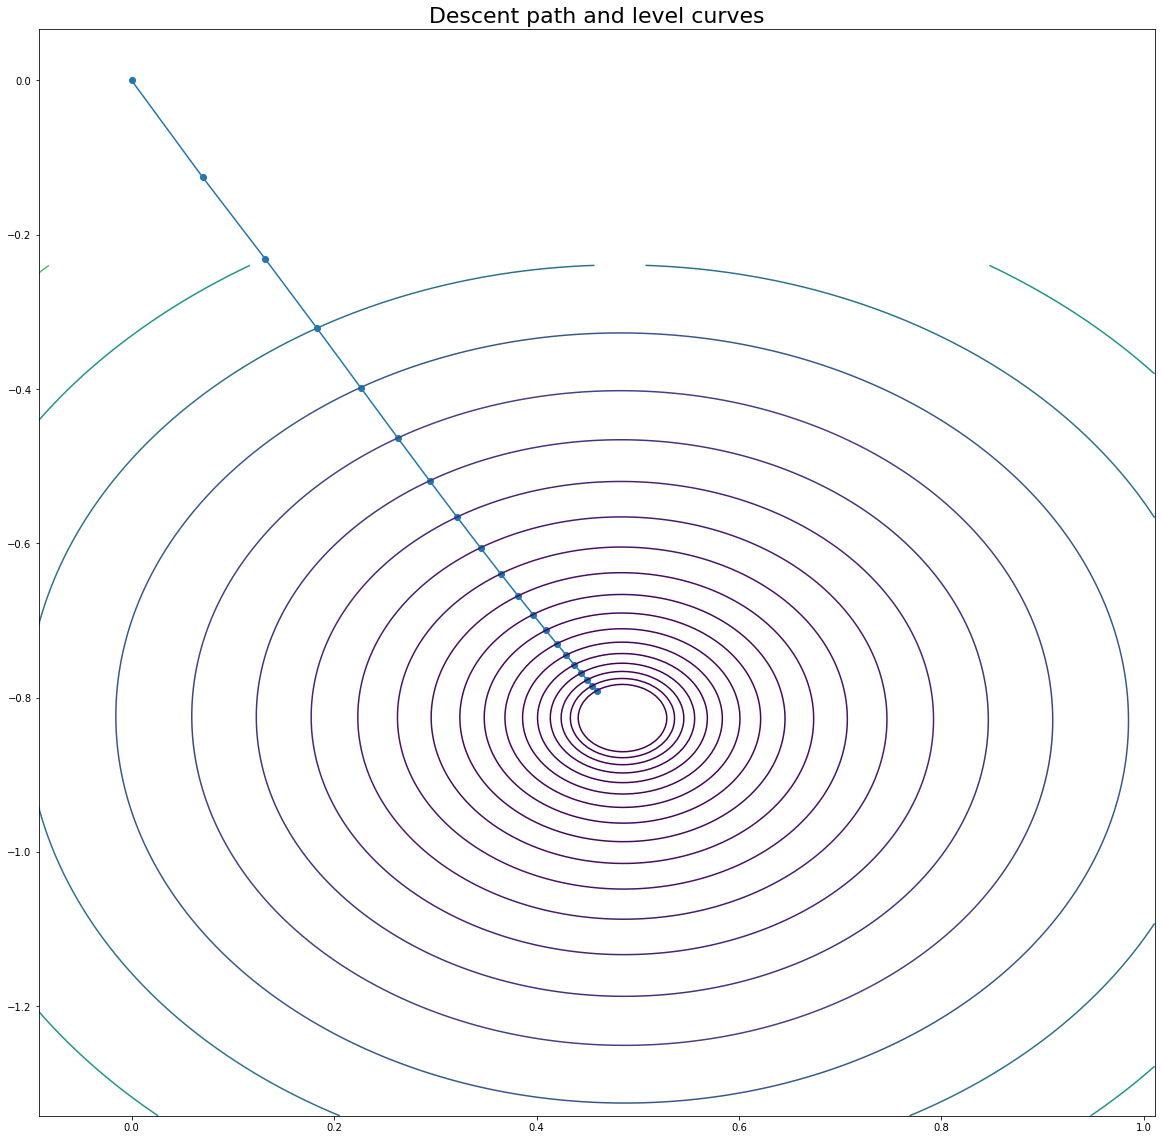

In [9]:
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(ParametrizedFun(lambda x, b: 0, 2), [0, 0], size=100, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
lr = 0.15
points = gauss_newton(sum_fun, x, 20, lr)

print_result(points)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Очень нелинейная функция

C:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Precision: [1.66533454e-16 1.33226763e-15]
Min point: [0.5 2. ]
Iterations: 20
Path: [[0.         0.        ]
 [0.26909003 0.20319537]
 [0.2689954  1.13122952]
 [0.36906333 1.89595892]
 [0.49770743 2.04166774]
 [0.49993681 1.99965144]
 [0.49999999 2.00000006]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]]


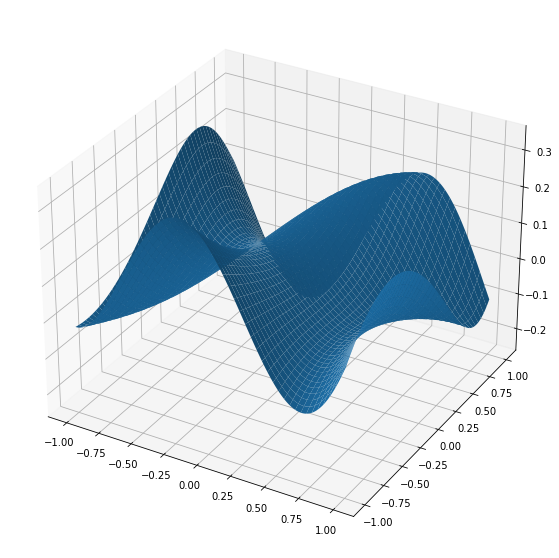

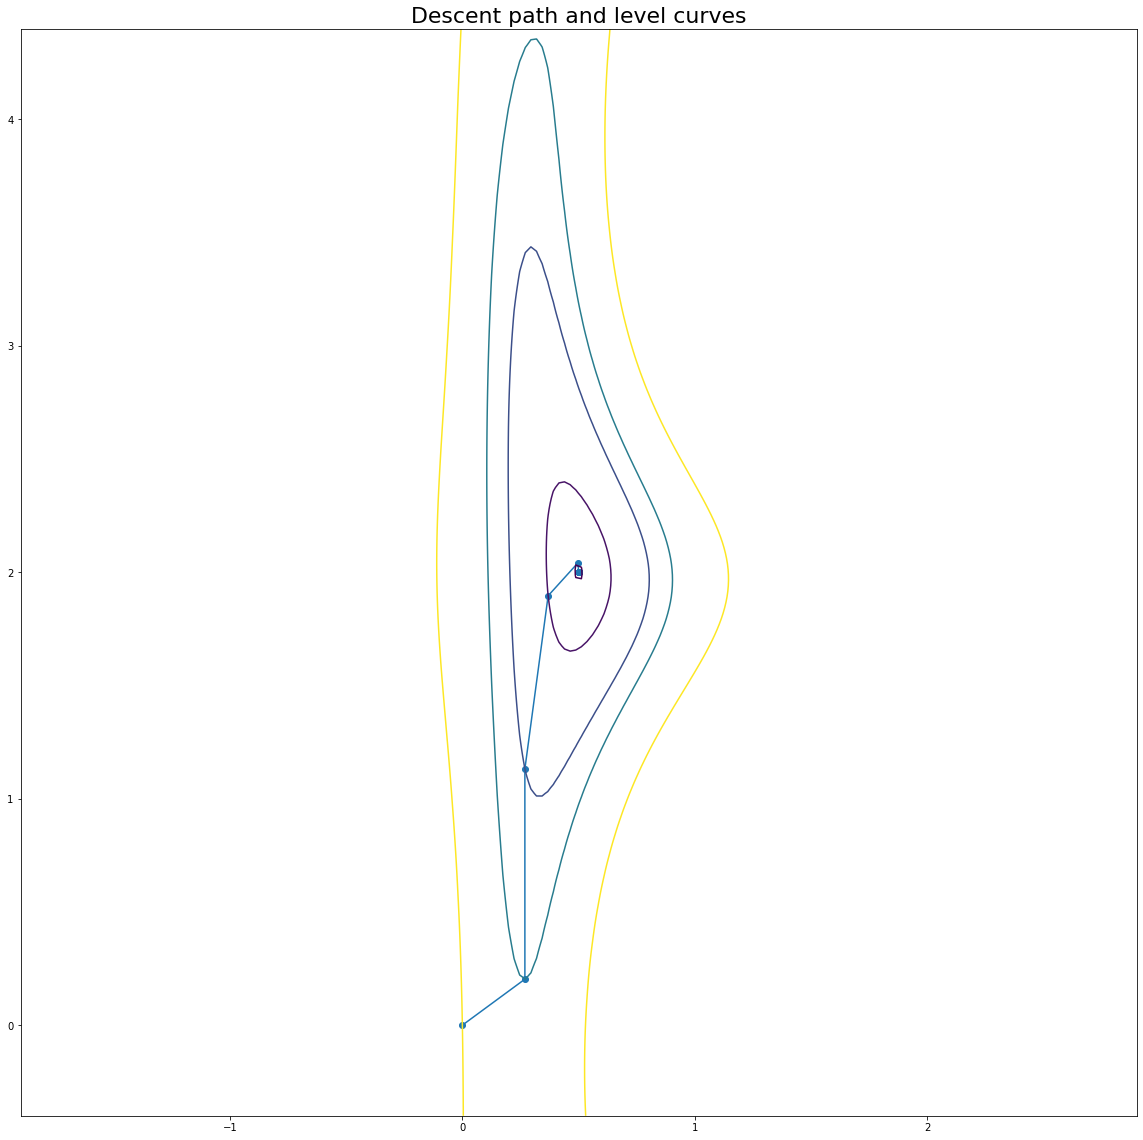

In [10]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
plot_path_contours(sum_fun, points)